# 1
### Method1 - using pyproj and coordinateSystems GeographicSystem

In [1]:
import numpy as np
from coordinateSystems import GeographicSystem

lat = np.array([33.5, 33.5 ]) 
lon = np.array([-101.5, 33.5]) 
alt = np.zeros_like(lat)

geo = GeographicSystem() 
X, Y, Z = geo.toECEF(lon, lat, alt) # Use degrees
print(X)
print(Y)
print(Z)

[-1061448.75418035  4439666.1356266 ]
[-5217187.30723133  2938550.91170072]
[ 3500334.28802236  3500334.28802236]


### Method2 - using Equations from WGS84 Manual

In [2]:
# convert to radians
latrad = (np.pi/180)*lat
lonrad = (np.pi/180)*lon

In [3]:
# from pg 80 of the manual, WGS 1984 values
a = 6378137
f = 1/298.257223563

In [4]:
ee = (f*(2-f))
nu = a / (np.sqrt(1-(ee*(np.sin(latrad)**2))))

In [5]:
X2 = (nu+alt)*np.cos(latrad)*np.cos(lonrad)
Y2 = (nu+alt)*np.cos(latrad)*np.sin(lonrad)
Z2 = (nu*(1-ee)+alt)*np.sin(latrad)
print X2
print Y2
print Z2

[-1061448.75418035  4439666.1356266 ]
[-5217187.30723133  2938550.91170072]
[ 3500334.28802236  3500334.28802236]


#### This demonstrates that the Method 2 ECEF conversion equals the ECEF transformation provided by the coordinate system library (Method 1)

# 2
### Using "toLocal" to make a "fromlocal" function, with testing

In [6]:
# Creating locations and stacking them into an array of shape 3xN
# List of lat, long, alt for three cities

loc = np.array([38.52, -121.50, 7,    # Sacramento
               42.36, -71.01, 3,      # Boston
               33.67, -101.82, 978,   # Lubbock
               40.48, -86.99, 217])   # West Lafayette

lats = loc[0::3]
lons = loc[1::3]
alts = loc[2::3]
coords = np.vstack((lats,lons,alts))

In [7]:
# toECEF, 3xN array
geo = GeographicSystem() 
X, Y, Z = geo.toECEF(lons, lats, alts) # Use degrees
stack = np.vstack((X,Y,Z))
print stack
stack.shape

[[-2610764.63460514  1535951.90343838 -1088600.50838782   255118.01042102]
 [-4260380.67367657 -4463258.63816954 -5201765.18521927 -4851739.41890332]
 [ 3950770.99911723  4275238.21034096  3516584.40093377  4118811.73878707]]


(3, 4)

In [8]:
# 'toLocal' function from the TangentPlaneCartesianSystem class within coordinateSystems.py
# The 'stack' of location values in ECEF are transformed to the local tangent plane cartesian system. 

lat0, lon0 = (33.582, -101.881) # centered at the ATMO building
from coordinateSystems import TangentPlaneCartesianSystem

tangent = TangentPlaneCartesianSystem(ctrLat=lat0,ctrLon=lon0,ctrAlt=978)
local = (tangent.toLocal(stack))
print local

[[ -1.67770917e+06   2.42194202e+06   5.65803626e+03   1.24852732e+06]
 [  7.07694102e+05   1.34041277e+06   9.76374118e+03   8.53958625e+05]
 [ -2.66232642e+05  -6.32598134e+05  -1.00059662e+01  -1.82728903e+05]]


### Derivation of mathematics to get "fromLocal" method

Start with equation for local tangent plane $\vec{q}$
$$\vec{q} = R\cdot(\hat{Q}-\hat{C})$$
Left multiply by $R^T$

And
$R^T\cdot{R} = 1$

$$R^T\cdot\vec{q} = \hat{Q}-\hat{C}$$
Add C
$$ \hat{Q} = (R^T\cdot\vec{q}) + \hat{C}$$
Ending with equation for ECEF $\hat{Q}$

### Below is the function "fromLocal" within the coordinateSystems.py TangentPlaneCartesianSystem class:

In [9]:
# FROM coordinateSystems.py


# def fromLocal(self, data):
#         """Transforms 3xN array of data (position vectors) in the local tangent 
#            plane cartesian system to the ECEF system.
#            Returns another 3xN array 
#         """
#         return array( [ dot(self.TransformToLocal.T, v) + self.centerECEF for v in 
#data[0:3,:].transpose()]).squeeze().transpose()

In [10]:
# Running fromLocal and testing
# taking 'local' 3xN array of data in the local tangent plane cartesian system and transforms to the ECEF system
# The resulting array matches the origingal array of locations, confirming the success of my "fromLocal" function

print 'These are the original locations in lat-long-alt'
print coords, '\n'

print 'toLocal from lat-long-alt'
print local, '\n'

for i in np.arange(len(lats)):
    tangent = TangentPlaneCartesianSystem(ctrLat=lat0,ctrLon=lon0,ctrAlt=978)
    new = (tangent.fromLocal(local))

print 'to ECEF fromLocal'
print new,'\n'

geo = GeographicSystem() 
X, Y, Z = geo.fromECEF(new[0], new[1], new[2]) # Use degrees
coords2 = np.vstack((Y,X,Z))

print 'to lat-long-alt fromECEF'
print coords2

These are the original locations in lat-long-alt
[[  38.52   42.36   33.67   40.48]
 [-121.5   -71.01 -101.82  -86.99]
 [   7.      3.    978.    217.  ]] 

toLocal from lat-long-alt
[[ -1.67770917e+06   2.42194202e+06   5.65803626e+03   1.24852732e+06]
 [  7.07694102e+05   1.34041277e+06   9.76374118e+03   8.53958625e+05]
 [ -2.66232642e+05  -6.32598134e+05  -1.00059662e+01  -1.82728903e+05]] 

to ECEF fromLocal
[[-2610764.63460514  1535951.90343838 -1088600.50838782   255118.01042102]
 [-4260380.67367659 -4463258.63816956 -5201765.18521927 -4851739.41890333]
 [ 3950770.99911723  4275238.21034096  3516584.40093377  4118811.73878708]] 

to lat-long-alt fromECEF
[[  38.52         42.36         33.67         40.48      ]
 [-121.5         -71.01       -101.82        -86.99      ]
 [   7.00000001    3.00000002  978.          217.00000002]]


# 3

In [11]:
# A friendly way for me to view the coords for plotting the local tangent plane 
# since its a 2D plot, I only looked at long,lat

local2 = local[:,:].T # The local coords transposed

sac = local2[0,:2]
bos = local2[1,:2]
lub = local2[2,:2]
wes = local2[3,:2]

print 'The local tangent plane coords that will be plotted\n'
print 'sacramento    ', sac
print 'boston        ', bos
print 'lubbock       ', lub
print 'west lafayette', wes

The local tangent plane coords that will be plotted

sacramento     [-1677709.1687431    707694.10231052]
boston         [ 2421942.02384256  1340412.76939171]
lubbock        [ 5658.03625936  9763.74118157]
west lafayette [ 1248527.32304714   853958.62495675]


In [12]:
# Use of MapProjection to do a projection

lat0, lon0 = (33.582, -101.881) # The ATMO building (0,0) centered location

from coordinateSystems import MapProjection
proj = MapProjection(projection='lcc',ctrLat=lat0,ctrLon=lon0) # using the lcc (Lambert conformal conic) projection
mpx,mpy,mpz = proj.fromECEF(new[0],new[1],new[2])

mp = np.vstack((mpy,mpx,mpz)) # The projection coords fromECEF

mp2 = mp[:,:].T # The projection coords transposed

sac2 = mp2[0,:2]
bos2 = mp2[1,:2]
lub2 = mp2[2,:2]
wes2 = mp2[3,:2]
print 'The projected coords that will be plotted\n'
print 'sacramento    ', sac2
print 'boston        ', bos2
print 'lubbock       ', lub2
print 'west lafayette', wes2

The projected coords that will be plotted

sacramento     [ 1837440.99037463   -77574.07044123]
boston         [-1631077.98713899  2337707.84569401]
lubbock        [  -850.0545198   11238.92440063]
west lafayette [ -750223.33524614  1322544.13198753]


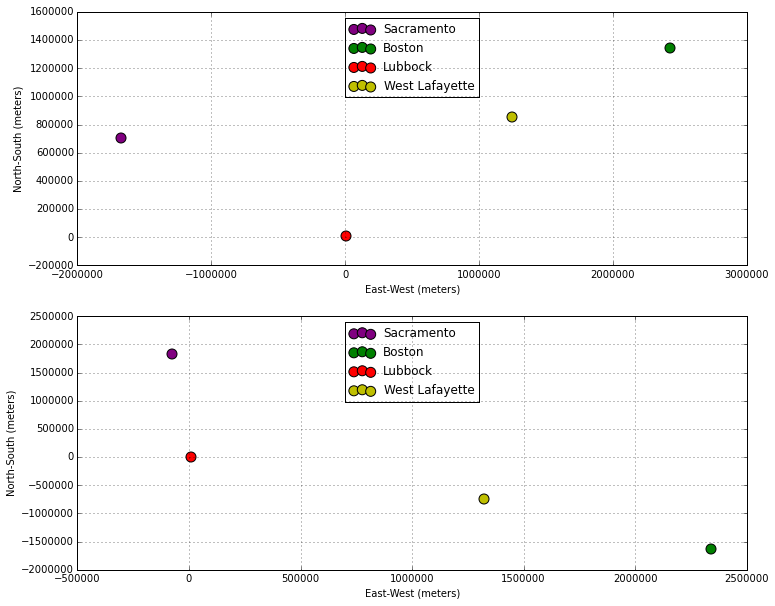

In [13]:
import matplotlib.pyplot as plt
% matplotlib inline

fig = plt.figure(figsize=(12,10))

# The first plot (local tangent plane)
ax = fig.add_subplot(211)

ax.scatter(sac[0],sac[1],label='Sacramento',s=100,c='purple') # for the sacramento kings
ax.scatter(bos[0],bos[1],label='Boston',s=100,c='g') # for the boston red socks
ax.scatter(lub[0],lub[1],label='Lubbock',s=100,c='r') # for the texas tech red raiders
ax.scatter(wes[0],wes[1],label='West Lafayette',s=100,c='y') # for the purdue boilermakers

ax.set_xlabel('East-West (meters)')
ax.set_ylabel('North-South (meters)')
ax.legend(loc='upper center')

# The second plot (Lcc Projection)
ax2 = fig.add_subplot(212)

ax2.scatter(sac2[1],sac2[0],label='Sacramento',s=100,c='purple') # for the sacramento kings
ax2.scatter(bos2[1],bos2[0],label='Boston',s=100,c='g') # for the boston red socks
ax2.scatter(lub2[1],lub2[0],label='Lubbock',s=100,c='r') # for the texas tech red raiders
ax2.scatter(wes2[1],wes2[0],label='West Lafayette',s=100,c='y') # for the purdue boilermakers

ax2.set_xlabel('East-West (meters)')
ax2.set_ylabel('North-South (meters)')
ax2.legend(loc='upper center')

ax.grid()
ax2.grid()
plt.show()

#### The main difference between the plots is that the locations on the LCC projection (second plot) are tilted to the right (Southwest) when compared to the local tangent plane (first plot). Boston is in the SouthWest and Sacramento is in the NorthEast in LCC coordinates. This is what I expected since the LCC projection (https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) shows the entire continent of North America tilting to the right relative to a normal world map projection or the local tangent plane, which points in true North. 